# install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks/master_thesis
!pip install transformers
!pip install pytorch-lightning
#!pip install git+https://github.com/facebookresearch/text-simplification-evaluation.git
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.optim as optim
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
#from torch.utils.data.sampler import BatchSampler
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import tqdm
import itertools
import pickle
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, spearmanr, pearsonr

# margin ranking model

In [ ]:
from ast import Add
from cProfile import label
import os
from random import shuffle
#import hydra
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
#from omegaconf import DictConfig
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy, auroc
from transformers import BertModel, BertTokenizer
#from tseval.feature_extraction import get_compression_ratio, get_wordrank_score
import spacy
#import nltk
#nltk.doenload('punkt')


class AugmentedDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int,
        orig_column_name: str,
        simp_column_name: str,
        sent_id_column_name: str,
        sys_name_column_name: str,
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.orig_column_name = orig_column_name
        self.simp_column_name = simp_column_name
        self.sent_id_column_name = sent_id_column_name
        self.sys_name_column_name = sys_name_column_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_row = self.data.iloc[index]
        orig = data_row[self.orig_column_name]
        simp = data_row[self.simp_column_name]
        sent_id = data_row[self.sent_id_column_name]
        sys_name = data_row[self.sys_name_column_name]

        encoding_orig_orig = self.tokenizer.encode_plus(
            #origin,
            orig,
            orig,
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        encoding_orig_simp = self.tokenizer.encode_plus(
            #origin,
            orig,
            simp,
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        encoding_simp_simp = self.tokenizer.encode_plus(
            #origin,
            simp,
            simp,
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        encoding_simp_orig = self.tokenizer.encode_plus(
            #origin,
            simp,
            orig,
            add_special_tokens=True,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            orig_orig=dict(
                input_ids=encoding_orig_orig["input_ids"].flatten(),
                attention_mask=encoding_orig_orig["attention_mask"].flatten(),
                #added_features=orig_orig_added_features_tensor.flatten(),
            ),
            orig_simp=dict(
                input_ids=encoding_orig_simp["input_ids"].flatten(),
                attention_mask=encoding_orig_simp["attention_mask"].flatten(),
                #added_features=orig_simp_added_features_tensor.flatten(),
                sents=simp
            ),
            simp_simp=dict(
                input_ids=encoding_simp_simp["input_ids"].flatten(),
                attention_mask=encoding_simp_simp["attention_mask"].flatten(),
                #added_features=orig_simp_added_features_tensor.flatten(),
                sents=simp
            ),
            simp_orig=dict(
                input_ids=encoding_simp_orig["input_ids"].flatten(),
                attention_mask=encoding_simp_orig["attention_mask"].flatten(),
                #added_features=orig_simp_added_features_tensor.flatten(),
            ),
            sent_ids=sent_id,
            sys_names=sys_name,
            #labels=torch.tensor(label),
            #case_nums=torch.tensor(case_num),
        )

class CreateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame=None,
        valid_df: pd.DataFrame=None,
        test_df: pd.DataFrame=None,
        batch_size: int=None,
        max_token_len: int=None,
        #origin_column_name: str = 'origin',
        orig_column_name: str = 'orig_sent',
        simp_column_name: str = 'simp_sent',
        sent_id_column_name: str = 'sent_id',
        sys_name_column_name: str = 'sys_name',
        #label_column_name: str = 'label',
        #case_num_column_name: str = 'case_number',
        pretrained_model='bert-base-uncased',
    ):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        #self.origin_column_name = origin_column_name
        self.orig_column_name = orig_column_name
        self.simp_column_name = simp_column_name
        self.sent_id_column_name = sent_id_column_name
        self.sys_name_column_name = sys_name_column_name
        #self.label_column_name = label_column_name
        #self.case_num_column_name = case_num_column_name
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model)

    def setup(self, stage):
        if stage == "test":
          self.test_dataset = AugmentedDataset(
              self.test_df,
              self.tokenizer,
              self.max_token_len,
              #self.origin_column_name,
              self.orig_column_name,
              self.simp_column_name,
              self.sent_id_column_name,
              self.sys_name_column_name,
              #self.label_column_name,
              #self.case_num_column_name,
            )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=os.cpu_count())

class BertRanker(pl.LightningModule):
    def __init__(
        self,
        n_classes: int,
        learning_rate: float,
        pooling_type: str,
        added_feature_num: int,
        pretrained_model='bert-base-uncased',
    ):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model, output_hidden_states=True, return_dict=True)
        classifier_hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(classifier_hidden_size + added_feature_num, n_classes)

        self.lr = learning_rate
        self.criterion = nn.MarginRankingLoss(margin=1.0)
        self.n_classes = n_classes
        self.pooling_type = pooling_type

        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-1].parameters():
            param.requires_grad = True
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        if self.pooling_type == 'cls':
            cls = output.pooler_output
            #output = torch.cat([added_features.float(), cls], dim=1)
            preds = self.classifier(cls)
        #preds = torch.flatten(preds)
        return preds, output

# prepare eval data

In [ ]:
def standardise_ratings(df, rater_id, aspect):
    return df.groupby(by=rater_id)[aspect].transform(lambda x: zscore(x))
df_simplicityDA = pd.read_csv("./src/metaeval-simplification/simplicity_DA.csv")

df_hg = pd.read_csv("./src/simplification_human_evaluations/questeval_simplification_likert_ratings.csv")
df_hg = df_hg[df_hg['simplification_type'] == 'human']
simplicity_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'simplicity'], rater_id='worker_id', aspect="rating")
meaning_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'meaning'], rater_id='worker_id', aspect="rating")
fluency_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'fluency'], rater_id='worker_id', aspect="rating")
df_hg_simp = df_hg[df_hg['aspect'] == 'simplicity'].copy().drop(columns=['aspect', 'rating'])
df_hg_simp['simplicity_zscore'] = simplicity_zscore
df_hg_simp['simplicity'] = df_hg[df_hg['aspect'] == 'simplicity']['rating']
df_hg_mean = df_hg[df_hg['aspect'] == 'meaning'].copy().drop(columns=['aspect', 'rating'])
df_hg_mean['meaning_zscore'] = meaning_zscore
df_hg_mean['meaning'] = df_hg[df_hg['aspect'] == 'meaning']['rating']
df_hg_flu = df_hg[df_hg['aspect'] == 'fluency'].copy().drop(columns=['aspect', 'rating'])
df_hg_flu['fluency_zscore'] = fluency_zscore
df_hg_flu['fluency'] = df_hg[df_hg['aspect'] == 'fluency']['rating']
df_hg_all = df_hg_simp.merge(df_hg_mean, on=['source', 'simplification', 'sentence_id', 'simplification_type', 'system_name', 'worker_id', 'references'])
df_hg_all = df_hg_all.merge(df_hg_flu, on=['source', 'simplification', 'sentence_id', 'simplification_type', 'system_name', 'worker_id', 'references'])
df_hg_all_grouped = df_hg_all.groupby(['sentence_id']).mean()
#df_hg_all_grouped['sentence_id'] = df_hg_all_grouped['sentence_id'].astype(int)
#df_hg_all_grouped['sentence_id'] = df_hg_all_grouped.index
df_hg_all_grouped.reset_index(inplace=True)
df_hg_all_ddup = df_hg_all.drop_duplicates(subset='sentence_id')
df_hg_all_grouped = df_hg_all_grouped.merge(df_hg_all_ddup.drop(columns=['worker_id', 'simplicity_zscore', 'meaning_zscore', 'fluency_zscore', 'simplicity', 'fluency', 'meaning']), on=['sentence_id'])
df_hg_all_grouped.rename(columns={'sentence_id': 'sent_id', 'system_name': 'sys_name', 'source': 'orig_sent', 'simplification': 'simp_sent'}, inplace=True)

simpda_2022 = pd.read_csv("./src/LENS-master/data/simpDA_2022.csv")
simplicity_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.simplicity")
fluency_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.fluency")
meaning_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.adequacy")
simpda_2022["simplicity_zscore"] = simplicity_zscore
simpda_2022["fluency_zscore"] = fluency_zscore
simpda_2022["meaning_zscore"] = meaning_zscore
simpda_2022['segment_id'] = simpda_2022['Input.id'].astype(str) + '_' + simpda_2022['Input.system']
simpda_2022["rater_num"] = simpda_2022.groupby(["segment_id"]).cumcount()
simpda_2022_grouped = simpda_2022.groupby(['segment_id']).mean().drop(['WorkerId', 'Answer.simplicity', 'Answer.fluency', 'Answer.adequacy', 'rater_num'], axis=1).astype({"Input.id":int}).reset_index()
simpda_2022_grouped['sent_id'] = simpda_2022_grouped['segment_id'].apply(lambda x: x.split(sep='_')[0]).astype(int)
simpda_2022_grouped['sys_name'] = simpda_2022_grouped['segment_id'].apply(lambda x: x.split(sep='_')[1]).astype(str)
simpda_2022_grouped = simpda_2022_grouped.merge(simpda_2022[['segment_id', 'Input.original', 'Input.simplified']].drop_duplicates(), on=['segment_id'])
#simpda_2022_grouped = simpda_2022_grouped.merge(simpda_2022[['segment_id', 'Input.original', 'Input.simplified']], on=['segment_id']).drop_duplicates()
simpda_2022_grouped.rename(columns={'Input.original': 'orig_sent', 'Input.simplified': 'simp_sent'}, inplace=True)

<ipython-input-2-eabad712060c>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hg_all_grouped = df_hg_all.groupby(['sentence_id']).mean()
<ipython-input-2-eabad712060c>:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simpda_2022_grouped = simpda_2022.groupby(['segment_id']).mean().drop(['WorkerId', 'Answer.simplicity', 'Answer.fluency', 'Answer.adequacy', 'rater_num'], axis=1).astype({"Input.id":int}).reset_index()


In [ ]:
simpda_2022[simpda_2022['Input.id'] == 9]

,WorkerId,Input.id,Input.original,Input.simplified,Input.system,Answer.adequacy,Answer.fluency,Answer.simplicity,simplicity_zscore,fluency_zscore,meaning_zscore,segment_id,rater_num
42,1,9,"Musk also announced the creation of a ""content...",Musk announced the creation of a “content mode...,Human 1 Writing,100,100,78,-0.365731,NaN,0.685778,9_Human 1 Writing,0
43,7,9,"Musk also announced the creation of a ""content...",Musk announced the creation of a “content mode...,Human 1 Writing,92,89,68,-0.190839,1.477646,1.660120,9_Human 1 Writing,1
44,6,9,"Musk also announced the creation of a ""content...",Musk announced the creation of a “content mode...,Human 1 Writing,100,100,77,0.209276,0.217286,0.487307,9_Human 1 Writing,2
168,6,9,"Musk also announced the creation of a ""content...",Musk said that he would create a “content mode...,Human 2 Writing,100,100,85,0.634318,0.217286,0.487307,9_Human 2 Writing,0
169,8,9,"Musk also announced the creation of a ""content...",Musk said that he would create a “content mode...,Human 2 Writing,100,100,98,0.649773,0.566534,0.562285,9_Human 2 Writing,1
170,7,9,"Musk also announced the creation of a ""content...",Musk said that he would create a “content mode...,Human 2 Writing,63,74,85,1.032055,0.032862,-0.607653,9_Human 2 Writing,2
294,5,9,"Musk also announced the creation of a ""content...","Musk announced the formation of a ""content mod...",GPT-3-zero-shot,100,80,50,-1.521934,-0.670790,0.596914,9_GPT-3-zero-shot,0
295,8,9,"Musk also announced the creation of a ""content...","Musk announced the formation of a ""content mod...",GPT-3-zero-shot,100,93,98,0.649773,0.262635,0.562285,9_GPT-3-zero-shot,1
296,7,9,"Musk also announced the creation of a ""content...","Musk announced the formation of a ""content mod...",GPT-3-zero-shot,75,75,60,-0.766319,0.129181,0.330736,9_GPT-3-zero-shot,2
432,2,9,"Musk also announced the creation of a ""content...","Musk also said he would create a ""content mode...",Muss,100,100,80,-0.121971,0.335071,0.569924,9_Muss,0


In [ ]:
simpda_2022_grouped[simpda_2022_grouped['sent_id'] == 9]

,segment_id,Input.id,simplicity_zscore,fluency_zscore,meaning_zscore,sent_id,sys_name,orig_sent,simp_sent
354,9_GPT-3-few-shot,9,-1.258135,0.529078,0.590441,9,GPT-3-few-shot,"Musk also announced the creation of a ""content...","Musk announced the formation of a ""content mod..."
355,9_GPT-3-zero-shot,9,-0.546160,-0.092991,0.496645,9,GPT-3-zero-shot,"Musk also announced the creation of a ""content...","Musk announced the formation of a ""content mod..."
356,9_Human 1 Writing,9,-0.115765,0.847466,0.944402,9,Human 1 Writing,"Musk also announced the creation of a ""content...",Musk announced the creation of a “content mode...
357,9_Human 2 Writing,9,0.772049,0.272227,0.147313,9,Human 2 Writing,"Musk also announced the creation of a ""content...",Musk said that he would create a “content mode...
358,9_Muss,9,0.619083,0.737038,0.838054,9,Muss,"Musk also announced the creation of a ""content...","Musk also said he would create a ""content mode..."
359,9_T5-3B,9,-0.653180,-0.060634,-0.071812,9,T5-3B,"Musk also announced the creation of a ""content...","Elon Musk also announced the creation of a "" c..."


In [ ]:
simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 1 Writing'].iloc[-1][['segment_id', 'simplicity_zscore', 'simp_sent']]

segment_id                                           9_Human 1 Writing
simplicity_zscore                                            -0.115765
simp_sent            Musk announced the creation of a “content mode...
Name: 356, dtype: object

In [ ]:
print(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 1 Writing'].iloc[-1]['simp_sent'])

Musk announced the creation of a “content moderation council” with diverse viewpoints in order to determine how the platform would deal with free speech. He announced a delay of “major content decisions or account reinstatements" until then.


In [ ]:
simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing'].iloc[-1][['segment_id', 'simplicity_zscore', 'simp_sent']]

segment_id                                           9_Human 2 Writing
simplicity_zscore                                             0.772049
simp_sent            Musk said that he would create a “content mode...
Name: 357, dtype: object

In [ ]:
print(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing'].iloc[-1]['simp_sent'])

Musk said that he would create a “content moderation council” with many different perspectives to handle free speech on the platform. He also declared that no “major content decisions or account reinstatements” would be made until the council was created.


In [ ]:
simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing']

,segment_id,Input.id,simplicity_zscore,fluency_zscore,meaning_zscore,sent_id,sys_name,orig_sent,simp_sent
3,0_Human 2 Writing,0,-0.387588,0.324404,0.314465,0,Human 2 Writing,The architecture of Winchester College is a di...,Winchester College’s architecture includes a v...
9,10_Human 2 Writing,10,0.837548,0.347422,0.502930,10,Human 2 Writing,The book is illustrated with more than 200 new...,The book has more than 200 new color photograp...
15,11_Human 2 Writing,11,0.506949,0.481999,-0.771069,11,Human 2 Writing,The last president to run after leaving office...,The last president to run after leaving office...
21,12_Human 2 Writing,12,-0.299857,0.035248,0.199421,12,Human 2 Writing,"On November 5, 2022, FIFA sent out a letter to...","On November 5, 2022, FIFA sent a letter to all..."
27,13_Human 2 Writing,13,0.351320,0.336214,0.122296,13,Human 2 Writing,Drone footage released by the Islamic State sh...,The Islamic State and the Syrian government we...
33,14_Human 2 Writing,14,1.095355,0.539133,0.361211,14,Human 2 Writing,"On November 2, 2022, Poland's Minister of Nati...","Recently, Poland’s Minister of National Defen..."
39,15_Human 2 Writing,15,-0.407045,0.160502,0.502930,15,Human 2 Writing,Major American and British oil producers repor...,Major American and British oil producers repor...
45,16_Human 2 Writing,16,-0.351524,0.209103,0.410150,16,Human 2 Writing,"In more recent practice, between the announcem...",The Judiciary Committee does an investigative ...
51,17_Human 2 Writing,17,0.697178,0.632552,-1.818902,17,Human 2 Writing,"Unlike the first film adaptation, in which dir...","Unlike the first film adaptation, which contai..."
57,18_Human 2 Writing,18,-0.050609,0.391910,-1.825581,18,Human 2 Writing,"Described as a darkly comedic bio-pic, Emilia ...","In the New York Magazine movie, “Who is Realit..."


PearsonRResult(statistic=-0.01523860437017895, pvalue=0.9080002023552239)


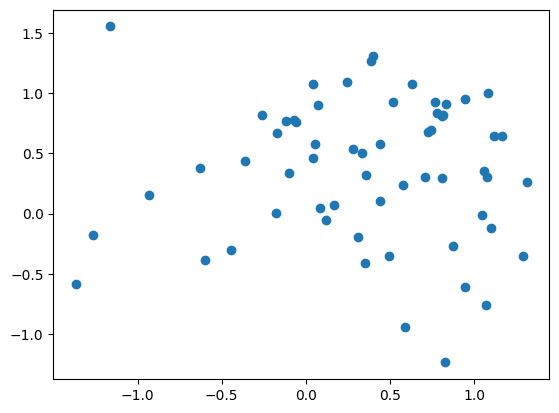

In [ ]:
plt.scatter(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 1 Writing']['simplicity_zscore'], simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing']['simplicity_zscore'])
print(pearsonr(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 1 Writing']['simplicity_zscore'], simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing']['simplicity_zscore']))


# setting

In [ ]:
max_token_len=512
learning_rate=0.05
pooling_type = 'cls'
added_feature_num = 0
feature_path = 'wo_features/'
metrics_segment_path = 'metrics_segment_c/'

# evaluation (human eval)

In [ ]:
ckpaths = ['exp2/gold/100/m=1/epoch=', 'exp2/silver/100/m=1/epoch='] #filtered_100
#ckpaths = ['exp2/gold/50/m=1/epoch=', 'exp2/silver/50/m=1/epoch='] #filtered_50
epoch_lists = [['3 (1)', '3', '4', '5 (1)', '5 (2)', '5', '6 (1)', '6 (2)', '6', '9'], ['4 (1)', '4', '5 (1)', '5', '6 (1)', '6', '7 (1)', '7', '8 (1)', '8']] #filtered_100
#epoch_lists = [['3', '4', '5 (1)', '5 (2)', '5', '6', '7 (1)', '7 (2)', '7', '9'], ['5 (1)', '5', '6 (1)', '6', '7 (1)', '7', '8', '9 (1)', '9 (2)', '9']] #filtered_50

for ckpath, epoch_list in zip(ckpaths, epoch_lists):
    df_metrics_segment_DA = pd.DataFrame()
    df_metrics_segment_hg = pd.DataFrame()
    df_metrics_segment_simpDA = pd.DataFrame()
    for i, epoch_num in tqdm.tqdm(enumerate(epoch_list)):
        now_model = 'model_' + str(i)
        model = BertRanker.load_from_checkpoint(
            n_classes=2,
            learning_rate=learning_rate,
            pooling_type=pooling_type,
            added_feature_num = added_feature_num,
            checkpoint_path='./lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath + epoch_num + '.ckpt', #filtered_100
            #checkpoint_path='./lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath + epoch_num + '.ckpt', #filtered_50
        )
        #model = nn.DataParallel(model, device_ids=[2,3])
        device = 'cuda'
        model.to(device)

        data_module = CreateDataModule(
        test_df=df_simplicityDA,
        batch_size=1,
        max_token_len=max_token_len,
        )
        data_module.setup(stage='test')
        test_dataloader = data_module.test_dataloader()
        metrics_DA = []
        sent_ids = []
        sys_names = []
        test_sets = []
        with torch.no_grad():
            print("start prediction of mr model")
            for batch in test_dataloader:
                input_ids=batch["orig_simp"]["input_ids"]
                attention_mask=batch["orig_simp"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_orig_simp, output = model(input_ids, attention_mask)
                preds_orig_simp = torch.nn.functional.softmax(preds_orig_simp)

                input_ids=batch["simp_orig"]["input_ids"]
                attention_mask=batch["simp_orig"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_simp_orig, output = model(input_ids, attention_mask)
                preds_simp_orig = torch.nn.functional.softmax(preds_simp_orig)

                #metrics_DA.append(preds_orig_simp[0].item() - preds_orig_orig[0].item())
                #metrics_DA.append(preds_orig_simp[0][1].item()) # pattern a
                #metrics_DA.append(preds_simp_orig[0][0].item()) # pattern b
                metrics_DA.append((preds_orig_simp[0][1].item() + preds_simp_orig[0][0].item()) / 2) # pattern c
                #metrics_DA.append(min(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern f
                #metrics_DA.append(max(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern g
                sent_ids.append(int(batch['sent_ids'][0]))
                sys_names.append(batch['sys_names'][0])
                test_sets.append('asset')

        if len(df_metrics_segment_DA) != 0:
            df_metrics_segment_DA = df_metrics_segment_DA.merge(pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_DA}), on=['sent_id', 'sys_name', 'test_set'])
        else:
            df_metrics_segment_DA = pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_DA})

        data_module = CreateDataModule(
        test_df=df_hg_all_grouped,
        batch_size=1,
        max_token_len=max_token_len,
        )
        data_module.setup(stage='test')
        test_dataloader = data_module.test_dataloader()
        metrics_hg = []
        sent_ids = []
        sys_names = []
        test_sets = []
        with torch.no_grad():
            print("start prediction of mr model")
            for batch in test_dataloader:
                input_ids=batch["orig_simp"]["input_ids"]
                attention_mask=batch["orig_simp"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_orig_simp, output = model(input_ids, attention_mask)
                preds_orig_simp = torch.nn.functional.softmax(preds_orig_simp)

                input_ids=batch["simp_orig"]["input_ids"]
                attention_mask=batch["simp_orig"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_simp_orig, output = model(input_ids, attention_mask)
                preds_simp_orig = torch.nn.functional.softmax(preds_simp_orig)

                #metrics_hg.append(preds_orig_simp[0].item() - preds_orig_orig[0].item())
                #metrics_hg.append(preds_orig_simp[0][1].item()) # pattern a
                #metrics_hg.append(preds_simp_orig[0][0].item()) # pattern b
                metrics_hg.append((preds_orig_simp[0][1].item() + preds_simp_orig[0][0].item()) / 2) # pattern c
                #metrics_hg.append(min(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern f
                #metrics_hg.append(max(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern g
                sent_ids.append(int(batch['sent_ids'][0]))
                sys_names.append(batch['sys_names'][0])
                test_sets.append('asset')
        if len(df_metrics_segment_hg) != 0:
            df_metrics_segment_hg = df_metrics_segment_hg.merge(pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_hg}), on=['sent_id', 'sys_name', 'test_set'])
        else:
            df_metrics_segment_hg = pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_hg})

        data_module = CreateDataModule(
        test_df=simpda_2022_grouped,
        batch_size=1,
        max_token_len=max_token_len,
        )
        data_module.setup(stage='test')
        test_dataloader = data_module.test_dataloader()
        metrics_simpDA = []
        sent_ids = []
        sys_names = []
        test_sets = []
        with torch.no_grad():
            print("start prediction of mr model")
            for batch in test_dataloader:
                input_ids=batch["orig_simp"]["input_ids"]
                attention_mask=batch["orig_simp"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_orig_simp, output = model(input_ids, attention_mask)
                preds_orig_simp = torch.nn.functional.softmax(preds_orig_simp)

                input_ids=batch["simp_orig"]["input_ids"]
                attention_mask=batch["simp_orig"]["attention_mask"]

                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                preds_simp_orig, output = model(input_ids, attention_mask)
                preds_simp_orig = torch.nn.functional.softmax(preds_simp_orig)

                #metrics_simpDA.append(preds_orig_simp[0].item() - preds_orig_orig[0].item())
                #metrics_simpDA.append(preds_orig_simp[0][1].item()) # pattern a
                #metrics_simpDA.append(preds_simp_orig[0][0].item()) # pattern b
                metrics_simpDA.append((preds_orig_simp[0][1].item() + preds_simp_orig[0][0].item()) / 2) # pattern c
                #metrics_simpDA.append(min(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern f
                #metrics_simpDA.append(max(preds_orig_simp[0][1].item(), preds_simp_orig[0][0].item())) # pattern g
                sent_ids.append(int(batch['sent_ids'][0]))
                sys_names.append(batch['sys_names'][0])
                test_sets.append('asset')

        if len(df_metrics_segment_simpDA) != 0:
            df_metrics_segment_simpDA = df_metrics_segment_simpDA.merge(pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_simpDA}), on=['sent_id', 'sys_name', 'test_set'])
        else:
            df_metrics_segment_simpDA = pd.DataFrame({'sent_id':sent_ids, 'sys_name':sys_names, 'test_set':test_sets, now_model:metrics_simpDA})



    save_name = feature_path.replace('/', '_') + ckpath[:-7].replace('/', '_')

    df_metrics_segment_DA_save = df_metrics_segment_DA[['sent_id', 'sys_name', 'test_set']].copy()
    df_metrics_segment_DA_save[save_name] = df_metrics_segment_DA.drop(columns=['sent_id', 'sys_name', 'test_set']).mean(axis=1)
    df_metrics_segment_DA_save = df_metrics_segment_DA_save.merge(df_metrics_segment_DA, on=['sent_id', 'sys_name', 'test_set'])
    with open('./lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_DA'  + '.pickle', 'wb') as f:
    #with open('./lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_DA'  + '.pickle', 'wb') as f:
        pickle.dump(df_metrics_segment_DA_save, f)

    df_metrics_segment_hg_save = df_metrics_segment_hg[['sent_id', 'sys_name', 'test_set']].copy()
    df_metrics_segment_hg_save[save_name] = df_metrics_segment_hg.drop(columns=['sent_id', 'sys_name', 'test_set']).mean(axis=1)
    df_metrics_segment_hg_save = df_metrics_segment_hg_save.merge(df_metrics_segment_hg, on=['sent_id', 'sys_name', 'test_set'])
    with open('./lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_hg'  + '.pickle', 'wb') as f:
    #with open('./lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_hg'  + '.pickle', 'wb') as f:
        pickle.dump(df_metrics_segment_hg_save, f)

    df_metrics_segment_simpDA_save = df_metrics_segment_simpDA[['sent_id', 'sys_name', 'test_set']].copy()
    df_metrics_segment_simpDA_save[save_name] = df_metrics_segment_simpDA.drop(columns=['sent_id', 'sys_name', 'test_set']).mean(axis=1)
    df_metrics_segment_simpDA_save = df_metrics_segment_simpDA_save.merge(df_metrics_segment_simpDA, on=['sent_id', 'sys_name', 'test_set'])
    with open('./lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_simpDA2022'  + '.pickle', 'wb') as f:
    #with open('./lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_simpDA2022'  + '.pickle', 'wb') as f:
        pickle.dump(df_metrics_segment_simpDA_save, f)

# correlations

## import

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore, pearsonr, spearmanr, t, kendalltau
from tqdm import tqdm


def compute_direct_assessment_correlations(df_human_scores, df_metrics_scores, aspect, segment_id_cols,
                                           use_absolute_values=True):
    df_da_scores = df_human_scores.reset_index()
    cols_of_interest = segment_id_cols + [f"{aspect}_zscore"]
    df_da_scores = df_da_scores[cols_of_interest]
    df_all_scores = pd.merge(left=df_metrics_scores, right=df_da_scores, on=segment_id_cols)

    # Compute correlations metrics vs human scores
    #print("Computing correlations...")
    metrics_names = [col for col in df_metrics_scores.columns if col not in segment_id_cols]
    correlations_data = []
    for metric in metrics_names:
        corr, p_value = pearsonr(df_all_scores[metric], df_all_scores[f'{aspect}_zscore'])
        if use_absolute_values:
            corr = abs(corr)
        correlations_data.append([metric, corr, p_value])
    df_correlations_metrics_human = pd.DataFrame(correlations_data, columns=['metric', 'corr', 'p_value'])
    df_correlations_metrics_human.sort_values(by=['corr'], ascending=False, inplace=True, ignore_index=True)

    # Compute correlations metrics vs metrics
    metrics_names = df_correlations_metrics_human['metric'].to_list()
    correlations_data = []
    for _, (metric_a, corr_metric_a, _) in df_correlations_metrics_human.iterrows():
        for _, (metric_b, corr_metric_b, _) in df_correlations_metrics_human.iterrows():
            corr_a_b, pvalue_a_b = pearsonr(df_all_scores[metric_a], df_all_scores[metric_b])
            if use_absolute_values:
                corr_a_b = abs(corr_a_b)
            correlations_data.append([metric_a, corr_metric_a,
                                      metric_b, corr_metric_b,
                                      corr_a_b, pvalue_a_b])
    df_correlations_metric_metric = pd.DataFrame(correlations_data,
                                                 columns=['metric_a', 'corr_metric_a',
                                                          'metric_b', 'corr_metric_b',
                                                          'corr_a_b', 'pvalue_a_b'])

    # Determine if the difference in performance is significant
    #print("Determining if the difference in performance is significant...")
    significance_matrix = []
    winner_status = []
    for metric_a in metrics_names:
        df_correlations = df_correlations_metric_metric[df_correlations_metric_metric['metric_a'] == metric_a]
        is_winner = True
        significance_row = []
        for _, (_, corr_metric_a, metric_b, corr_metric_b, corr_a_b, _) in df_correlations.iterrows():
            p = np.nan
            if (metric_a != metric_b) and (corr_metric_a > corr_metric_b):
                _, p = williams_test(corr_metric_a, corr_metric_b, corr_a_b, len(df_human_scores))
            is_diff_stats_significant = p < 0.05
            if not is_diff_stats_significant:
                # we do not care about the exact values in cases where it's not significant
                p = np.nan
            significance_row.append(p)
            # Update winner status (not significantly outperformed by any other metric)
            if metric_a != metric_b:
                is_winner = is_winner and is_diff_stats_significant
        significance_matrix.append(significance_row)
        winner_status.append(is_winner)
    df_correlations_metrics_human['is_winner'] = winner_status
    df_significance = pd.DataFrame(np.array(significance_matrix), columns=metrics_names, index=metrics_names)

    return df_correlations_metrics_human, df_significance

def compute_relative_ranking_correlations(df_human_scores, df_metrics_scores, aspect, segment_id_cols,
                                           use_absolute_values=True):
    df_da_scores = df_human_scores.reset_index()
    cols_of_interest = segment_id_cols + [f"{aspect}_zscore"]
    df_da_scores = df_da_scores[cols_of_interest]
    df_all_scores = pd.merge(left=df_metrics_scores, right=df_da_scores, on=segment_id_cols)

    # Compute correlations metrics vs human scores
    #print("Computing correlations...")
    metrics_names = [col for col in df_metrics_scores.columns if col not in segment_id_cols]
    correlations_data = []
    for metric in metrics_names:
        corr, p_value = spearmanr(df_all_scores[metric], df_all_scores[f'{aspect}_zscore'])
        if use_absolute_values:
            corr = abs(corr)
        correlations_data.append([metric, corr, p_value])
    df_correlations_metrics_human = pd.DataFrame(correlations_data, columns=['metric', 'corr', 'p_value'])
    df_correlations_metrics_human.sort_values(by=['corr'], ascending=False, inplace=True, ignore_index=True)

    # Compute correlations metrics vs metrics
    metrics_names = df_correlations_metrics_human['metric'].to_list()
    correlations_data = []
    for _, (metric_a, corr_metric_a, _) in df_correlations_metrics_human.iterrows():
        for _, (metric_b, corr_metric_b, _) in df_correlations_metrics_human.iterrows():
            corr_a_b, pvalue_a_b = spearmanr(df_all_scores[metric_a], df_all_scores[metric_b])
            if use_absolute_values:
                corr_a_b = abs(corr_a_b)
            correlations_data.append([metric_a, corr_metric_a,
                                      metric_b, corr_metric_b,
                                      corr_a_b, pvalue_a_b])
    df_correlations_metric_metric = pd.DataFrame(correlations_data,
                                                 columns=['metric_a', 'corr_metric_a',
                                                          'metric_b', 'corr_metric_b',
                                                          'corr_a_b', 'pvalue_a_b'])

    # Determine if the difference in performance is significant
    #print("Determining if the difference in performance is significant...")
    significance_matrix = []
    winner_status = []
    for metric_a in metrics_names:
        df_correlations = df_correlations_metric_metric[df_correlations_metric_metric['metric_a'] == metric_a]
        is_winner = True
        significance_row = []
        for _, (_, corr_metric_a, metric_b, corr_metric_b, corr_a_b, _) in df_correlations.iterrows():
            p = np.nan
            if (metric_a != metric_b) and (corr_metric_a > corr_metric_b):
                _, p = williams_test(corr_metric_a, corr_metric_b, corr_a_b, len(df_human_scores))
            is_diff_stats_significant = p < 0.05
            if not is_diff_stats_significant:
                # we do not care about the exact values in cases where it's not significant
                p = np.nan
            significance_row.append(p)
            # Update winner status (not significantly outperformed by any other metric)
            if metric_a != metric_b:
                is_winner = is_winner and is_diff_stats_significant
        significance_matrix.append(significance_row)
        winner_status.append(is_winner)
    df_correlations_metrics_human['is_winner'] = winner_status
    df_significance = pd.DataFrame(np.array(significance_matrix), columns=metrics_names, index=metrics_names)

    return df_correlations_metrics_human, df_significance


def compute_kendall_tau_correlations(df_human_scores, df_metrics_scores, aspect, segment_id_cols,
                                           use_absolute_values=True):
    df_da_scores = df_human_scores.reset_index()
    cols_of_interest = segment_id_cols + [f"{aspect}_zscore"]
    df_da_scores = df_da_scores[cols_of_interest]
    df_all_scores = pd.merge(left=df_metrics_scores, right=df_da_scores, on=segment_id_cols)

    # Compute correlations metrics vs human scores
    #print("Computing correlations...")
    metrics_names = [col for col in df_metrics_scores.columns if col not in segment_id_cols]
    correlations_data = []
    for metric in metrics_names:
        corr, p_value = kendalltau(df_all_scores[metric], df_all_scores[f'{aspect}_zscore'])
        if use_absolute_values:
            corr = abs(corr)
        correlations_data.append([metric, corr, p_value])
    df_correlations_metrics_human = pd.DataFrame(correlations_data, columns=['metric', 'corr', 'p_value'])
    df_correlations_metrics_human.sort_values(by=['corr'], ascending=False, inplace=True, ignore_index=True)

    # Compute correlations metrics vs metrics
    metrics_names = df_correlations_metrics_human['metric'].to_list()
    correlations_data = []
    for _, (metric_a, corr_metric_a, _) in df_correlations_metrics_human.iterrows():
        for _, (metric_b, corr_metric_b, _) in df_correlations_metrics_human.iterrows():
            corr_a_b, pvalue_a_b = kendalltau(df_all_scores[metric_a], df_all_scores[metric_b])
            if use_absolute_values:
                corr_a_b = abs(corr_a_b)
            correlations_data.append([metric_a, corr_metric_a,
                                      metric_b, corr_metric_b,
                                      corr_a_b, pvalue_a_b])
    df_correlations_metric_metric = pd.DataFrame(correlations_data,
                                                 columns=['metric_a', 'corr_metric_a',
                                                          'metric_b', 'corr_metric_b',
                                                          'corr_a_b', 'pvalue_a_b'])

    # Determine if the difference in performance is significant
    #print("Determining if the difference in performance is significant...")
    significance_matrix = []
    winner_status = []
    for metric_a in metrics_names:
        df_correlations = df_correlations_metric_metric[df_correlations_metric_metric['metric_a'] == metric_a]
        is_winner = True
        significance_row = []
        for _, (_, corr_metric_a, metric_b, corr_metric_b, corr_a_b, _) in df_correlations.iterrows():
            p = np.nan
            if (metric_a != metric_b) and (corr_metric_a > corr_metric_b):
                _, p = williams_test(corr_metric_a, corr_metric_b, corr_a_b, len(df_human_scores))
            is_diff_stats_significant = p < 0.05
            if not is_diff_stats_significant:
                # we do not care about the exact values in cases where it's not significant
                p = np.nan
            significance_row.append(p)
            # Update winner status (not significantly outperformed by any other metric)
            if metric_a != metric_b:
                is_winner = is_winner and is_diff_stats_significant
        significance_matrix.append(significance_row)
        winner_status.append(is_winner)
    df_correlations_metrics_human['is_winner'] = winner_status
    df_significance = pd.DataFrame(np.array(significance_matrix), columns=metrics_names, index=metrics_names)

    return df_correlations_metrics_human, df_significance


# From https://github.com/inmoonlight/nlp-williams/blob/master/williams.py
def williams_test(r12, r13, r23, n):

    """The Williams test (Evan J. Williams. 1959. Regression Analysis, volume 14. Wiley, New York, USA)
    A test of whether the population correlation r12 equals the population correlation r13.
    Significant: p < 0.05
    Arguments:
        r12 (float): correlation between x1, x2
        r13 (float): correlation between x1, x3
        r23 (float): correlation between x2, x3
        n (int): size of the population
    Returns:
        t (float): Williams test result
        p (float): p-value of t-dist
    """
    assert (r12 >= r13), "r12 should be larger than r13"
    assert (n > 3), "n should be larger than 3"

    K = 1 - r12 ** 2 - r13 ** 2 - r23 ** 2 + 2 * r12 * r13 * r23
    denominator = np.sqrt(
        2 * K * (n - 1) / (n - 3) + (((r12 + r13) ** 2) / 4) * ((1 - r23) ** 3)
    )
    numerator = (r12 - r13) * np.sqrt((n - 1) * (1 + r23))
    p = 1 - t.cdf(numerator / denominator, df=n - 3)  # changed to n-3 on 30/11/14
    return t, p

In [ ]:
def compute_direct_correlations(df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols):
    results = {}
    for aspect in aspects:
        smed = df_benchmark['simplicity_zscore'].median()
        shind = df_benchmark['simplicity_zscore'] > smed
        slind = df_benchmark['simplicity_zscore'] <= smed
        fmed = df_benchmark['fluency_zscore'].median()
        fhind = df_benchmark['fluency_zscore'] > fmed
        flind = df_benchmark['fluency_zscore'] <= fmed
        mmed = df_benchmark['meaning_zscore'].median()
        mhind = df_benchmark['meaning_zscore'] > mmed
        mlind = df_benchmark['meaning_zscore'] <= mmed
        fmhind = (df_benchmark['fluency_zscore'] > fmed) & (df_benchmark['meaning_zscore'] > mmed)
        fmlind = (df_benchmark['fluency_zscore'] <= fmed) & (df_benchmark['meaning_zscore'] <= mmed)
        smfhind = (df_benchmark['simplicity_zscore'] > smed) & (df_benchmark['fluency_zscore'] > fmed) & (df_benchmark['meaning_zscore'] > mmed)
        smflind = (df_benchmark['simplicity_zscore'] <= smed) & (df_benchmark['fluency_zscore'] <= fmed) & (df_benchmark['meaning_zscore'] <= mmed)
        df_scores_slow = df_benchmark[slind]
        df_scores_shigh = df_benchmark[shind]
        df_scores_flow = df_benchmark[flind]
        df_scores_fhigh = df_benchmark[fhind]
        df_scores_mlow = df_benchmark[mlind]
        df_scores_mhigh = df_benchmark[mhind]
        df_scores_fmlow = df_benchmark[fmlind]
        df_scores_fmhigh = df_benchmark[fmhind]
        df_scores_sfmlow = df_benchmark[smflind]
        df_scores_sfmhigh = df_benchmark[smfhind]

        print(f"{aspect}: simp_high ({len(df_scores_shigh)}) - simp_low ({len(df_scores_slow)}) - flu_low ({len(df_scores_flow)}) - flu_high ({len(df_scores_fhigh)}) - mean_low ({len(df_scores_mlow)}) - mean_high ({len(df_scores_mhigh)}) - fm_low ({len(df_scores_fmlow)}) - fm_high ({len(df_scores_fmhigh)}) - sfm_low ({len(df_scores_sfmlow)}) - sfm_high ({len(df_scores_sfmhigh)}) - All ({len(df_benchmark)})")
        for quality, df_scores in {'simp_low': df_scores_slow, 'simp_high': df_scores_shigh, 'flu_low': df_scores_flow, 'flu_high': df_scores_fhigh, 'mean_low': df_scores_mlow, 'mean_high': df_scores_mhigh, 'fm_low': df_scores_fmlow, 'fm_high': df_scores_fmhigh, 'sfm_low': df_scores_sfmlow, 'sfm_high': df_scores_sfmhigh, 'all': df_benchmark}.items():
            for test_set in test_sets:
                #print(f"Computing for {quality} scores - {test_set} references")
                df_metrics = df_segment_metrics[df_segment_metrics.test_set==test_set].drop(columns=['test_set'])
                results[(quality, aspect, test_set)] = compute_direct_assessment_correlations(
                    df_scores,
                    df_metrics,
                    aspect,
                    segment_id_cols=segment_id_cols,
                    use_absolute_values=False
                )
                #print()
    return results

def compute_ranking_correlations(df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols):
    results = {}
    for aspect in aspects:
        smed = df_benchmark['simplicity_zscore'].median()
        shind = df_benchmark['simplicity_zscore'] > smed
        slind = df_benchmark['simplicity_zscore'] <= smed
        fmed = df_benchmark['fluency_zscore'].median()
        fhind = df_benchmark['fluency_zscore'] > fmed
        flind = df_benchmark['fluency_zscore'] <= fmed
        mmed = df_benchmark['meaning_zscore'].median()
        mhind = df_benchmark['meaning_zscore'] > mmed
        mlind = df_benchmark['meaning_zscore'] <= mmed
        fmhind = (df_benchmark['fluency_zscore'] > fmed) & (df_benchmark['meaning_zscore'] > mmed)
        fmlind = (df_benchmark['fluency_zscore'] <= fmed) & (df_benchmark['meaning_zscore'] <= mmed)
        smfhind = (df_benchmark['simplicity_zscore'] > smed) & (df_benchmark['fluency_zscore'] > fmed) & (df_benchmark['meaning_zscore'] > mmed)
        smflind = (df_benchmark['simplicity_zscore'] <= smed) & (df_benchmark['fluency_zscore'] <= fmed) & (df_benchmark['meaning_zscore'] <= mmed)
        df_scores_slow = df_benchmark[slind]
        df_scores_shigh = df_benchmark[shind]
        df_scores_flow = df_benchmark[flind]
        df_scores_fhigh = df_benchmark[fhind]
        df_scores_mlow = df_benchmark[mlind]
        df_scores_mhigh = df_benchmark[mhind]
        df_scores_fmlow = df_benchmark[fmlind]
        df_scores_fmhigh = df_benchmark[fmhind]
        df_scores_sfmlow = df_benchmark[smflind]
        df_scores_sfmhigh = df_benchmark[smfhind]

        print(f"{aspect}: simp_high ({len(df_scores_shigh)}) - simp_low ({len(df_scores_slow)}) - flu_low ({len(df_scores_flow)}) - flu_high ({len(df_scores_fhigh)}) - mean_low ({len(df_scores_mlow)}) - mean_high ({len(df_scores_mhigh)}) - fm_low ({len(df_scores_fmlow)}) - fm_high ({len(df_scores_fmhigh)}) - sfm_low ({len(df_scores_sfmlow)}) - sfm_high ({len(df_scores_sfmhigh)}) - All ({len(df_benchmark)})")
        for quality, df_scores in {'simp_low': df_scores_slow, 'simp_high': df_scores_shigh, 'flu_low': df_scores_flow, 'flu_high': df_scores_fhigh, 'mean_low': df_scores_mlow, 'mean_high': df_scores_mhigh, 'fm_low': df_scores_fmlow, 'fm_high': df_scores_fmhigh, 'sfm_low': df_scores_sfmlow, 'sfm_high': df_scores_sfmhigh, 'all': df_benchmark}.items():
            for test_set in test_sets:
                #print(f"Computing for {quality} scores - {test_set} references")
                df_metrics = df_segment_metrics[df_segment_metrics.test_set==test_set].drop(columns=['test_set'])
                results[(quality, aspect, test_set)] = compute_relative_ranking_correlations(
                    df_human_scores=df_scores,
                    df_metrics_scores=df_metrics,
                    aspect=aspect,
                    segment_id_cols=segment_id_cols,
                    #sentence_id_cols=['sent_id'],
                    #system_id_cols=['sys_name'],
                    use_absolute_values=False,
                )
                #print()
    return results

def compute_kendall_correlations(df_benchmark, df_segment_metrics, aspects, test_sets, segment_id_cols):
    results = {}
    for aspect in aspects:
        smed = df_benchmark['simplicity_zscore'].median()
        shind = df_benchmark['simplicity_zscore'] > smed
        slind = df_benchmark['simplicity_zscore'] <= smed
        fmed = df_benchmark['fluency_zscore'].median()
        fhind = df_benchmark['fluency_zscore'] > fmed
        flind = df_benchmark['fluency_zscore'] <= fmed
        mmed = df_benchmark['meaning_zscore'].median()
        mhind = df_benchmark['meaning_zscore'] > mmed
        mlind = df_benchmark['meaning_zscore'] <= mmed
        fmhind = (df_benchmark['fluency_zscore'] > fmed) & (df_benchmark['meaning_zscore'] > mmed)
        fmlind = (df_benchmark['fluency_zscore'] <= fmed) & (df_benchmark['meaning_zscore'] <= mmed)
        df_scores_slow = df_benchmark[slind]
        df_scores_shigh = df_benchmark[shind]
        df_scores_flow = df_benchmark[flind]
        df_scores_fhigh = df_benchmark[fhind]
        df_scores_mlow = df_benchmark[mlind]
        df_scores_mhigh = df_benchmark[mhind]
        df_scores_fmlow = df_benchmark[fmlind]
        df_scores_fmhigh = df_benchmark[fmhind]

        print(f"{aspect}: simp_high ({len(df_scores_shigh)}) - simp_low ({len(df_scores_slow)}) - flu_low ({len(df_scores_flow)}) - flu_high ({len(df_scores_fhigh)}) - mean_low ({len(df_scores_mlow)}) - mean_high ({len(df_scores_mhigh)}) - fm_low ({len(df_scores_fmlow)}) - fm_high ({len(df_scores_fmhigh)}) - All ({len(df_benchmark)})")
        for quality, df_scores in {'simp_low': df_scores_slow, 'simp_high': df_scores_shigh, 'flu_low': df_scores_flow, 'flu_high': df_scores_fhigh, 'mean_low': df_scores_mlow, 'mean_high': df_scores_mhigh, 'fm_low': df_scores_fmlow, 'fm_high': df_scores_fmhigh, 'all': df_benchmark}.items():
            for test_set in test_sets:
                #print(f"Computing for {quality} scores - {test_set} references")
                df_metrics = df_segment_metrics[df_segment_metrics.test_set==test_set].drop(columns=['test_set'])
                results[(quality, aspect, test_set)] = compute_kendall_tau_correlations(
                    df_human_scores=df_scores,
                    df_metrics_scores=df_metrics,
                    aspect=aspect,
                    segment_id_cols=segment_id_cols,
                    #sentence_id_cols=['sent_id'],
                    #system_id_cols=['sys_name'],
                    use_absolute_values=False,
                )
                #print()
    return results

In [ ]:
def standardise_ratings(df, rater_id, aspect):
    return df.groupby(by=rater_id)[aspect].transform(lambda x: zscore(x))
df_simplicityDA = pd.read_csv("./src/metaeval-simplification/simplicity_DA.csv")

df_hg = pd.read_csv("./src/simplification_human_evaluations/questeval_simplification_likert_ratings.csv")
df_hg = df_hg[df_hg['simplification_type'] == 'human']
simplicity_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'simplicity'], rater_id='worker_id', aspect="rating")
meaning_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'meaning'], rater_id='worker_id', aspect="rating")
fluency_zscore = standardise_ratings(df_hg[df_hg['aspect'] == 'fluency'], rater_id='worker_id', aspect="rating")
df_hg_simp = df_hg[df_hg['aspect'] == 'simplicity'].copy().drop(columns=['aspect', 'rating'])
df_hg_simp['simplicity_zscore'] = simplicity_zscore
df_hg_simp['simplicity'] = df_hg[df_hg['aspect'] == 'simplicity']['rating']
df_hg_mean = df_hg[df_hg['aspect'] == 'meaning'].copy().drop(columns=['aspect', 'rating'])
df_hg_mean['meaning_zscore'] = meaning_zscore
df_hg_mean['meaning'] = df_hg[df_hg['aspect'] == 'meaning']['rating']
df_hg_flu = df_hg[df_hg['aspect'] == 'fluency'].copy().drop(columns=['aspect', 'rating'])
df_hg_flu['fluency_zscore'] = fluency_zscore
df_hg_flu['fluency'] = df_hg[df_hg['aspect'] == 'fluency']['rating']
df_hg_all = df_hg_simp.merge(df_hg_mean, on=['source', 'simplification', 'sentence_id', 'simplification_type', 'system_name', 'worker_id', 'references'])
df_hg_all = df_hg_all.merge(df_hg_flu, on=['source', 'simplification', 'sentence_id', 'simplification_type', 'system_name', 'worker_id', 'references'])
df_hg_all_grouped = df_hg_all.groupby(['sentence_id']).mean()
#df_hg_all_grouped['sentence_id'] = df_hg_all_grouped['sentence_id'].astype(int)
#df_hg_all_grouped['sentence_id'] = df_hg_all_grouped.index
df_hg_all_grouped.reset_index(inplace=True)
df_hg_all_ddup = df_hg_all.drop_duplicates(subset='sentence_id')
df_hg_all_grouped = df_hg_all_grouped.merge(df_hg_all_ddup.drop(columns=['worker_id', 'simplicity_zscore', 'meaning_zscore', 'fluency_zscore', 'simplicity', 'fluency', 'meaning']), on=['sentence_id'])
df_hg_all_grouped.rename(columns={'sentence_id': 'sent_id', 'system_name': 'sys_name', 'source': 'orig_sent', 'simplification': 'simp_sent'}, inplace=True)

simpda_2022 = pd.read_csv("./src/LENS-master/data/simpDA_2022.csv")
simplicity_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.simplicity")
fluency_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.fluency")
meaning_zscore = standardise_ratings(simpda_2022, rater_id='WorkerId', aspect="Answer.adequacy")
simpda_2022["simplicity_zscore"] = simplicity_zscore
simpda_2022["fluency_zscore"] = fluency_zscore
simpda_2022["meaning_zscore"] = meaning_zscore
simpda_2022['segment_id'] = simpda_2022['Input.id'].astype(str) + '_' + simpda_2022['Input.system']
simpda_2022["rater_num"] = simpda_2022.groupby(["segment_id"]).cumcount()
simpda_2022_grouped = simpda_2022.groupby(['segment_id']).mean().drop(['WorkerId', 'Answer.simplicity', 'Answer.fluency', 'Answer.adequacy', 'rater_num'], axis=1).astype({"Input.id":int}).reset_index()
simpda_2022_grouped['sent_id'] = simpda_2022_grouped['segment_id'].apply(lambda x: x.split(sep='_')[0]).astype(int)
simpda_2022_grouped['sys_name'] = simpda_2022_grouped['segment_id'].apply(lambda x: x.split(sep='_')[1]).astype(str)
simpda_2022_grouped = simpda_2022_grouped.merge(simpda_2022[['segment_id', 'Input.original', 'Input.simplified']].drop_duplicates(), on=['segment_id'])
#simpda_2022_grouped = simpda_2022_grouped.merge(simpda_2022[['segment_id', 'Input.original', 'Input.simplified']], on=['segment_id']).drop_duplicates()
simpda_2022_grouped.rename(columns={'Input.original': 'orig_sent', 'Input.simplified': 'simp_sent'}, inplace=True)

<ipython-input-4-eabad712060c>:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hg_all_grouped = df_hg_all.groupby(['sentence_id']).mean()
<ipython-input-4-eabad712060c>:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simpda_2022_grouped = simpda_2022.groupby(['segment_id']).mean().drop(['WorkerId', 'Answer.simplicity', 'Answer.fluency', 'Answer.adequacy', 'rater_num'], axis=1).astype({"Input.id":int}).reset_index()


In [ ]:
METRICS_TO_ANALYSE = ['bleu', 'sari', 'fkgl', 'fkbleu', 'ibleu',
                      'amean_bleu_sari',
                      'gmean_bleu_sari',
                      'bertscore_P', 'bertscore_R', 'bertscore_F1']

## calculation

In [ ]:
import pickle
feature_path = 'wo_features/'
#metrics_segment_path = 'metrics_segment_a/'
#metrics_segment_path = 'metrics_segment_b/'
metrics_segment_path = 'metrics_segment_c/'
#ckpaths = ['exp1/25/epoch=', 'exp1/50/epoch=', 'exp1/75/epoch=']
ckpaths = ['exp1/100/epoch=', 'exp2/gold/100/m=1/epoch=', 'exp2/silver/100/m=1/epoch='] #Base
#ckpaths = ['exp2/gold/100/m=1/epoch=', 'exp2/silver/100/m=1/epoch='] #filtered_100
#ckpaths = ['exp2/gold/50/m=1/epoch=', 'exp2/silver/50/m=1/epoch='] #filtered_50

In [ ]:
df_metrics_segment_DA_all = pd.DataFrame()
df_metrics_segment_hg_all = pd.DataFrame()
df_metrics_segment_simpDA_all = pd.DataFrame()
#for ckpath in ckpaths:
ckpath = ckpaths[0] #change here
save_name = feature_path.replace('/', '_') + ckpath[:-7].replace('/', '_')
path_DA = './lightning_logs_folder/v11_nprm/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_DA'  + '.pickle' #Base
path_hg = './lightning_logs_folder/v11_nprm/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_hg'  + '.pickle' #Base
path_simpDA = './lightning_logs_folder/v11_nprm/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_simpDA2022'  + '.pickle' #Base
# path_DA = './lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_DA'  + '.pickle' #filtered_100
# path_hg = './lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_hg'  + '.pickle' #filtered_100
# path_simpDA = './lightning_logs_folder/v11_nprm_filtered/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_simpDA2022'  + '.pickle' #filtered_100
#path_DA = './lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_DA'  + '.pickle' #filtered_50
#path_hg = './lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_hg'  + '.pickle' #filtered_50
#path_simpDA = './lightning_logs_folder/v11_nprm_filtered_50/' + feature_path + ckpath[:5] + metrics_segment_path + save_name + '_simpDA2022'  + '.pickle' #filtered_50

with open(path_DA, 'rb') as f:
    df_metrics_segment_DA = pickle.load(f)
with open(path_hg, 'rb') as f:
    df_metrics_segment_hg = pickle.load(f)
with open(path_simpDA, 'rb') as f:
    df_metrics_segment_simpDA = pickle.load(f)

if len(df_metrics_segment_DA_all) != 0:
    df_metrics_segment_DA_all = df_metrics_segment_DA_all.merge(df_metrics_segment_DA, on=['sent_id', 'sys_name', 'test_set'])
else:
    df_metrics_segment_DA_all = df_metrics_segment_DA
if len(df_metrics_segment_hg_all) != 0:
    df_metrics_segment_hg_all = pd.concat([df_metrics_segment_hg_all, df_metrics_segment_hg.drop(columns=['sent_id', 'sys_name', 'test_set'])], axis=1)
else:
    df_metrics_segment_hg_all = df_metrics_segment_hg
if len(df_metrics_segment_simpDA_all) != 0:
    df_metrics_segment_simpDA_all = df_metrics_segment_simpDA_all.merge(df_metrics_segment_simpDA, on=['sent_id', 'sys_name', 'test_set'])
else:
    df_metrics_segment_simpDA_all = df_metrics_segment_simpDA

Text(0.5, 1.0, 'Simplicity-DA')

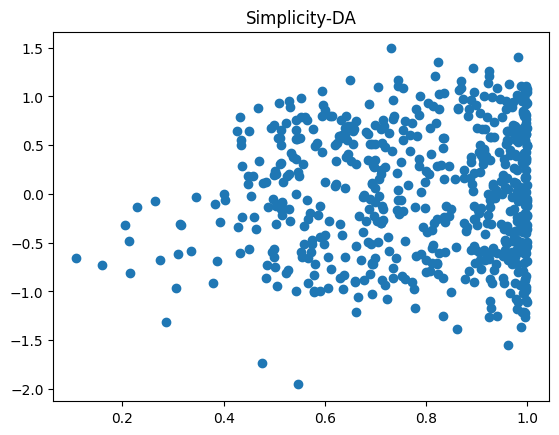

In [ ]:
plt.scatter(df_metrics_segment_DA_all['wo_features_exp2_silver_100_m=1'], df_simplicityDA['simplicity_zscore'])
plt.title('Simplicity-DA')

Text(0.5, 1.0, 'Human-Likert')

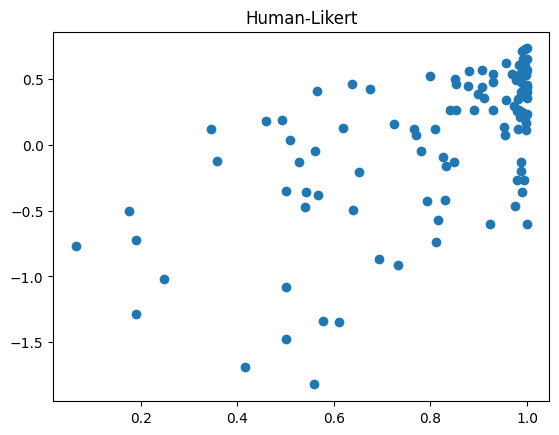

In [ ]:
plt.scatter(df_metrics_segment_hg_all['wo_features_exp2_silver_100_m=1'], df_hg_all_grouped['simplicity_zscore'])
plt.title('Human-Likert')

Text(0.5, 1.0, 'SimpDA_2022')

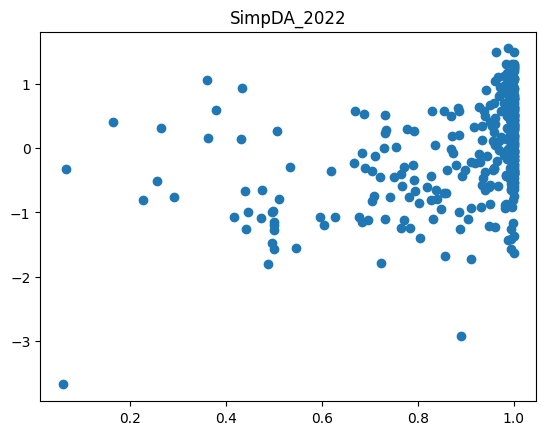

In [ ]:
plt.scatter(df_metrics_segment_simpDA_all['wo_features_exp2_silver_100_m=1'], simpda_2022_grouped['simplicity_zscore'])
plt.title('SimpDA_2022')

## simplicity-DA

### direct assessment (pearson r)

In [ ]:
results_simplicity = compute_direct_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.029978191564565625
0.015166886010837459
[0.046293985167247725, 0.043814689582357076, 0.0400094361078448, 0.03940003116121509, 0.03828749338688652, 0.032504326218685375, 0.024865407666108737, 0.024699639544020005, 0.009500682842444095, 0.0004062239688467927]


In [ ]:
results_simplicity = compute_direct_correlations(
                        df_simplicityDA[df_simplicityDA['sys_name'] == 'ACCESS'],
                        df_metrics_segment_DA_all[df_metrics_segment_DA_all['sys_name'] == 'ACCESS'],
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

In [ ]:
sn = 'SBMT-SARI'
print(df_simplicityDA[df_simplicityDA['sys_name'] == sn]['fluency_zscore'].mean())
print(df_simplicityDA[df_simplicityDA['sys_name'] == sn]['meaning_zscore'].mean())
print(df_simplicityDA[df_simplicityDA['sys_name'] == sn]['simplicity_zscore'].mean())

In [ ]:
results_simplicity = compute_direct_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.2856466735902097
0.03691592537979936
[0.32446702200044625, 0.31790162434099717, 0.31689121664141146, 0.31297516664516417, 0.2930343736350443, 0.2881565284190292, 0.28058634051374554, 0.2713306592179557, 0.24109908990922643, 0.2100247145790765]


In [ ]:
results_simplicity = compute_direct_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.13392684115597006
0.016929475489650105
[0.15511866178461609, 0.14594931042466097, 0.14363970884053714, 0.1420867193295629, 0.1414950881999089, 0.13697890342598287, 0.1321447650829691, 0.13212163478563876, 0.11047523972272061, 0.09925837996310337]


### relative ranking (spearmanr)

In [ ]:
results_simplicity = compute_ranking_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.01662611386183423
0.011580135876005834
[0.03212256323615144, 0.024557736588000062, 0.02409842938999442, 0.02236792479756371, 0.022158923894728844, 0.018948859243990104, 0.017960190025541084, 0.008485218485896832, -0.0016375046623396676, -0.0028012023811845284]


In [ ]:
results_simplicity = compute_ranking_correlations(
                        df_simplicityDA[df_simplicityDA['sys_name'] == 'ACCESS'],
                        df_metrics_segment_DA_all[df_metrics_segment_DA_all['sys_name'] == 'ACCESS'],
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

In [ ]:
results_simplicity = compute_ranking_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('sfm_high', 'simplicity', 'asset')][0][results_simplicity[('sfm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.3164531132700351
0.039353574236243555
[0.3637256870737306, 0.34091727708014047, 0.3408041195712631, 0.33933944702677915, 0.3386302203866319, 0.3216263124681347, 0.3078960034684296, 0.29785526676522106, 0.2880935542036377, 0.22564324465638338]


In [ ]:
results_simplicity = compute_ranking_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('sfm_low', 'simplicity', 'asset')][0][results_simplicity[('sfm_low', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - sfm_low (208) - sfm_high (196) - All (600)
0.08754153931499468
0.02349500132872668
[0.11741957508547896, 0.1114773860769284, 0.10976780656414523, 0.09578846020493617, 0.0890474895051554, 0.08360670603233532, 0.08226117894310113, 0.07573223877571703, 0.07329455441583586, 0.037019997546313334]


### kendall tau

In [ ]:
results_simplicity = compute_kendall_correlations(
                        df_simplicityDA,
                        df_metrics_segment_DA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('fm_high', 'simplicity', 'asset')][0][results_simplicity[('fm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('fm_high', 'simplicity', 'asset')][0][results_simplicity[('fm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('fm_high', 'simplicity', 'asset')][0][results_simplicity[('fm_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (300) - simp_low (300) - flu_low (300) - flu_high (300) - mean_low (300) - mean_high (300) - fm_low (222) - fm_high (222) - All (600)
0.2624739918522979
0.019076137276867466
[0.28631415970259494, 0.2826450333501482, 0.2737575939631105, 0.27253455184562825, 0.26894696163434695, 0.262144037890531, 0.26209792577644636, 0.25345509481290507, 0.23453871006251298, 0.2283058494847548]


## Human-Generated data

### direct assessment (pearson r)

In [ ]:
results_simplicity = compute_direct_correlations(
                        df_hg_all_grouped,
                        df_metrics_segment_hg_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (50) - simp_low (50) - flu_low (50) - flu_high (50) - mean_low (50) - mean_high (50) - fm_low (35) - fm_high (35) - sfm_low (26) - sfm_high (22) - All (100)
0.5495363994902213
0.03482372494140101
[0.6129240963034974, 0.5830457533328359, 0.5732681915328215, 0.5627592231570289, 0.5451352811096831, 0.5431295067336943, 0.540981464340939, 0.529868002266282, 0.5052415833009319, 0.499010892824499]


### relative ranking (spearman r)

In [ ]:
results_simplicity = compute_ranking_correlations(
                        df_hg_all_grouped,
                        df_metrics_segment_hg_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (50) - simp_low (50) - flu_low (50) - flu_high (50) - mean_low (50) - mean_high (50) - fm_low (35) - fm_high (35) - sfm_low (26) - sfm_high (22) - All (100)
0.5416348930857513
0.02616848346257269
[0.5738973897389739, 0.5684085460828046, 0.563996399639964, 0.5527272727272726, 0.5472187218721871, 0.5417461746174617, 0.5398499849984998, 0.5302446151977517, 0.5006900690069006, 0.4975697569756975]


### kendall tau

In [ ]:
results_simplicity = compute_kendall_correlations(
                        df_hg_all_grouped,
                        df_metrics_segment_hg_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('mean_high', 'simplicity', 'asset')][0][results_simplicity[('mean_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('mean_high', 'simplicity', 'asset')][0][results_simplicity[('mean_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('mean_high', 'simplicity', 'asset')][0][results_simplicity[('mean_high', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (50) - simp_low (50) - flu_low (50) - flu_high (50) - mean_low (50) - mean_high (50) - fm_low (35) - fm_high (35) - All (100)
0.4597551020408163
0.02886355357337609
[0.5053061224489797, 0.5036734693877551, 0.47265306122448986, 0.4644897959183673, 0.4563265306122449, 0.44816326530612244, 0.44816326530612244, 0.44653061224489793, 0.44326530612244897, 0.4089795918367347]


## SimpDA_2022

### direct assessment (pearson r)

In [ ]:
results_simplicity = compute_direct_correlations(
                        simpda_2022_grouped,
                        df_metrics_segment_simpDA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (180) - simp_low (180) - flu_low (180) - flu_high (180) - mean_low (180) - mean_high (180) - fm_low (106) - fm_high (106) - sfm_low (53) - sfm_high (54) - All (360)
0.3948344508281974
0.02569005792333863
[0.4300698999838229, 0.4193084233544191, 0.41706488789154156, 0.40853513561749644, 0.4041611126442876, 0.39797776789241496, 0.38232757583514826, 0.37134887689889867, 0.36122785684328235, 0.3563229713206619]


In [ ]:
results_simplicity = compute_direct_correlations(
                        simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'Human 2 Writing'],
                        df_metrics_segment_simpDA_all[df_metrics_segment_simpDA_all['sys_name'] == 'Human 2 Writing'],
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (30) - simp_low (30) - flu_low (30) - flu_high (30) - mean_low (30) - mean_high (30) - fm_low (17) - fm_high (17) - All (60)
0.23000360896405803
0.04033367957470315
[0.316784962852361, 0.26395752446323906, 0.24617750550040648, 0.23526899313792773, 0.2334335788780091, 0.22893919170922067, 0.20351856326674522, 0.20045598134614612, 0.19480142057633013, 0.17669836791019486]


In [ ]:
sn = 'T5-3B'
print(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == sn]['fluency_zscore'].mean())
print(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == sn]['meaning_zscore'].mean())
print(simpda_2022_grouped[simpda_2022_grouped['sys_name'] == sn]['simplicity_zscore'].mean())

-0.009551484881418305
-0.1661552451129783
-0.2640072922219319


### relative ranking (spearman r)

In [ ]:
results_simplicity = compute_ranking_correlations(
                        simpda_2022_grouped,
                        df_metrics_segment_simpDA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (180) - simp_low (180) - flu_low (180) - flu_high (180) - mean_low (180) - mean_high (180) - fm_low (106) - fm_high (106) - sfm_low (53) - sfm_high (54) - All (360)
0.40119618560794335
0.0287941405905316
[0.4463270609504524, 0.44071564861812834, 0.41661705315479974, 0.41107266916574314, 0.4014704847864677, 0.40128398632731216, 0.38776257932166935, 0.37631455185026524, 0.3734676125246914, 0.35693020937990455]


In [ ]:
results_simplicity = compute_ranking_correlations(
                        simpda_2022_grouped[simpda_2022_grouped['sys_name'] == 'T5-3B'],
                        df_metrics_segment_simpDA_all[df_metrics_segment_simpDA_all['sys_name'] == 'T5-3B'],
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (30) - simp_low (30) - flu_low (31) - flu_high (29) - mean_low (30) - mean_high (30) - fm_low (19) - fm_high (18) - All (60)
0.7199873669138854
0.02815146936972891
[0.7622672964712421, 0.7499131691911426, 0.7429111269281403, 0.7328702417338151, 0.720126703691387, 0.719330906943615, 0.7096254317949534, 0.7059052451079104, 0.6796982453871477, 0.6772253018895001]


### kendall tau

In [ ]:
results_simplicity = compute_kendall_correlations(
                        simpda_2022_grouped,
                        df_metrics_segment_simpDA_all,
                        aspects=['simplicity'],
                        test_sets=['asset'],
                        segment_id_cols=['sent_id','sys_name']
                    )
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].mean())
print(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"].std())
print(list(results_simplicity[('all', 'simplicity', 'asset')][0][results_simplicity[('all', 'simplicity', 'asset')][0]["metric"] != save_name]["corr"]))

simplicity: simp_high (180) - simp_low (180) - flu_low (180) - flu_high (180) - mean_low (180) - mean_high (180) - fm_low (106) - fm_high (106) - All (360)
0.26461905397272967
0.013376067754323857
[0.2956761274302498, 0.27115863755242264, 0.2700268494885033, 0.267108236127191, 0.2650923103112088, 0.2624615051300701, 0.26021959656295607, 0.25511269993103364, 0.2513715325473195, 0.24796304464634225]


# permutation test

In [ ]:
from scipy.stats import permutation_test
import numpy as np
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

## pearson

In [ ]:
base_a_sda =[0.05643898405832946, 0.05328775584348712, 0.03793785957856535, 0.029991750525143974, 0.009423621651486398, 0.003924238640734612, -6.5114847114186e-05, -0.010145161041055468, -0.02161004208755353, -0.03311010159242153]
base_a_hl =[0.524327969321161, 0.5068725090549833, 0.48873455868947263, 0.4405265784957374, 0.4358123949537476, 0.4327660627806369, 0.3914917015275515, 0.3877922473282435, 0.3722206222342308, 0.36051264867892446]
base_a_simpda2022 = [0.3786763098076278, 0.3739768164561473, 0.36801151415600936, 0.2988665672310331, 0.29618746702827203, 0.29609676520627787, 0.2880094916903373, 0.26837484174093473, 0.26770309997568964, 0.24672540440563231]
fsilver_a_sda = [0.07468885482814773, 0.044799803043376996, 0.03998675682865272, 0.029394535843820107, 0.024209016687586918, 0.020035711311767117, 0.0035449440151142557, -0.0038263554385555335, -0.012842418549406086, -0.04708579748704649]
fsilver_a_hl = [0.5849916532938787, 0.5401122365272345, 0.4907371143641313, 0.4546486380847076, 0.4463700911539928, 0.44266352856124336, 0.42075397973995526, 0.40886457531842474, 0.37547426894512603, 0.3638150079939784]
fsilver_a_simpda2022 = [0.3663999726808605, 0.2881736593547642, 0.2758457735520356, 0.2665794670744271, 0.26366464997103933, 0.2369493665362392, 0.23402229898926816, 0.2307633266236448, 0.20263180333527772, 0.19067130995115253]
print("Simplicity-DA, pattern a: ", permutation_test((base_a_sda, fsilver_a_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern a: ", permutation_test((base_a_hl, fsilver_a_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern a: ", permutation_test((base_a_simpda2022, fsilver_a_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern a:  0.732
Human-Likert, pattern a:  0.508
SimpDA_2022, pattern a:  0.026


In [ ]:
base_b_sda = [0.09083060049773979, 0.07443801469903748, 0.05101555127980971, 0.04698227211120474, 0.03574949811540604, 0.03548611100820337, 0.009078063594394656, 0.007907038954936347, 0.003311605934507801, 0.0006544643264898644]
base_b_hl = [0.5157830185945153, 0.5129594629386539, 0.5036207200175112, 0.4971938983860832, 0.48171515101264795, 0.45685773340990227, 0.4284964661078574, 0.4231593237644066, 0.4020741227284648, 0.36405285517781233]
base_b_simpda2022 = [0.39657481200457034, 0.3783808420285943, 0.37645288773832664, 0.3466972491667655, 0.3381897497191072, 0.3250439645333405, 0.31772727580895177, 0.30351096576288766, 0.29390482758411607, 0.2691269881623371]
fsilver_b_sda = [0.09178695019359775, 0.08300416608546149, 0.08233192828181278, 0.07145718772190726, 0.06427123545349402, 0.056351377530538815, 0.05084376173833517, 0.047402451254283384, 0.0354477582782602, 0.015320837474713979]
fsilver_b_hl = [0.6492323837588561, 0.6185083927814284, 0.610540792772684, 0.571144658593771, 0.5655050151606977, 0.5571167756836597, 0.5566514765443711, 0.5269514132944838, 0.47988996383460897, 0.45493179869027733]
fsilver_b_simpda2022 = [0.3841982030695444, 0.37039673949451957, 0.3680894624903404, 0.36366139539991454, 0.36301711059393177, 0.3445622360602361, 0.3419190178047793, 0.32446587525060383, 0.2746387524254481, 0.2374241524994956]
print("Simplicity-DA, pattern b: ", permutation_test((base_b_sda, fsilver_b_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern b: ", permutation_test((base_b_hl, fsilver_b_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern b: ", permutation_test((base_b_simpda2022, fsilver_b_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern b:  0.0666
Human-Likert, pattern b:  0.0012
SimpDA_2022, pattern b:  0.8944


In [ ]:
base_c_sda = [0.046293985167247725, 0.043814689582357076, 0.0400094361078448, 0.03940003116121509, 0.03828749338688652, 0.032504326218685375, 0.024865407666108737, 0.024699639544020005, 0.009500682842444095, 0.0004062239688467927]
base_c_hl = [0.6129240963034974, 0.5830457533328359, 0.5732681915328215, 0.5627592231570289, 0.5451352811096831, 0.5431295067336943, 0.540981464340939, 0.529868002266282, 0.5052415833009319, 0.499010892824499]
base_c_simpda2022 = [0.4300698999838229, 0.4193084233544191, 0.41706488789154156, 0.40853513561749644, 0.4041611126442876, 0.39797776789241496, 0.38232757583514826, 0.37134887689889867, 0.36122785684328235, 0.3563229713206619]
fsilver_c_sda = [0.06639583653458778, 0.06505492860628444, 0.06172550999040373, 0.060182243429891154, 0.0571100660957997, 0.056846427930076354, 0.04754601986158138, 0.02811952951787979, 0.0247368277200636, 0.024184263433227292]
fsilver_c_hl = [0.6376935336402444, 0.6087757823137948, 0.5978306123236116, 0.5954741594429677, 0.5925218576211664, 0.5917558676509089, 0.574412316487163, 0.5516069626422169, 0.534598745432838, 0.518963434035443]
fsilver_c_simpda2022 = [0.41553557777337014, 0.39768963045500744, 0.3802140304386636, 0.37185937431993255, 0.36800806884332554, 0.36504200219714844, 0.35694499992499706, 0.34555133940558114, 0.33964038641382654, 0.3281188631256553]
print("Simplicity-DA, pattern c: ", permutation_test((base_c_sda, fsilver_c_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern c: ", permutation_test((base_c_hl, fsilver_c_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern c: ", permutation_test((base_c_simpda2022, fsilver_c_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern c:  0.0176
Human-Likert, pattern c:  0.0656
SimpDA_2022, pattern c:  0.0308


## spearman

In [ ]:
base_a_sda =[0.021251699987526452, 0.020429252894806967, 0.013896567344393165, -0.0012479479976297183, -0.0016888659431442323, -0.0017915052003414983, -0.007124714631135909, -0.011892117688340063, -0.013417454682788288, -0.015619794473025967]
base_a_hl = [0.5295649564956495, 0.5000900090009001, 0.4803960396039604, 0.4668466846684668, 0.4525892589258925, 0.4400733275547186, 0.42951095109510945, 0.4156615661566156, 0.4123012301230123, 0.3914671467146714]
base_a_simpda2022 = [0.3677243618226715, 0.354176164462871, 0.3530144114455719, 0.3521443818560837, 0.3409074468512703, 0.33588325111174205, 0.3255481801639164, 0.3186297472169814, 0.31338472049190796, 0.2986179028971141]
fsilver_a_sda = [0.05933153086521352, 0.03468615479649857, 0.02501162711659989, 0.008509607562077106, 0.006344407129059414, -0.0027635356845604406, -0.01153994952346742, -0.01404378979073776, -0.016890964758996926, -0.049452112336540587]
fsilver_a_hl =[0.5545394539453945, 0.5107710771077107, 0.5089348934893488, 0.5086948694869486, 0.5086108610861085, 0.5033423342334232, 0.4685868586858686, 0.4544854485448544, 0.45002100210020995, 0.3673567356735673]
fsilver_a_simpda2022 = [0.43649414855085794, 0.3966615978232218, 0.36411608378932886, 0.3596477645906818, 0.35563177077076236, 0.3555652464275548, 0.33574378192420185, 0.30554476550255766, 0.2990793456196717, 0.21947969960136007]
print("Simplicity-DA, pattern a: ", permutation_test((base_a_sda, fsilver_a_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern a: ", permutation_test((base_a_hl, fsilver_a_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern a: ", permutation_test((base_a_simpda2022, fsilver_a_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern a:  0.7354
Human-Likert, pattern a:  0.16
SimpDA_2022, pattern a:  0.7438


In [ ]:
base_b_sda = [0.05994233733582172, 0.05506087899278059, 0.04976083543347824, 0.035678184421522575, 0.019549805391115303, 0.016909326157238787, 0.007962883672614862, 0.002428312469500787, 0.0005667516057962171, -0.0011009197859393948]
base_b_hl = [0.05994233733582172, 0.05506087899278059, 0.04976083543347824, 0.035678184421522575, 0.019549805391115303, 0.016909326157238787, 0.007962883672614862, 0.002428312469500787, 0.0005667516057962171, -0.0011009197859393948]
base_b_simpda2022 = [0.42420812261114227, 0.38627195932683966, 0.3857166813830081, 0.373786159303228, 0.3717770991741021, 0.3716632238878018, 0.37094410615725093, 0.3489985388258012, 0.345773422003499, 0.28285754299255694]
fsilver_b_sda = [0.08324881920498786, 0.07734488795898525, 0.06831238799621052, 0.06525699045036192, 0.05394157025030431, 0.03468012651980476, 0.03420887517804746, 0.02704510440557363, 0.016379851965136145, 0.005395682179252957]
fsilver_b_hl =[0.5777497749774977, 0.5743054305430543, 0.5222442244224422, 0.49579506689412134, 0.49413741374137415, 0.4869006900690068, 0.4825082508250825, 0.4733513351335133, 0.47251125112511244, 0.4395079507950795]
fsilver_b_simpda2022 = [0.4422472964358389, 0.4217742977262496, 0.416115559555931, 0.38224530140168606, 0.3798846119840926, 0.37869095390048774, 0.3720606275488209, 0.36628185564237054, 0.3449086585963966, 0.34470699748335576]
print("Simplicity-DA, pattern b: ", permutation_test((base_b_sda, fsilver_b_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern b: ", permutation_test((base_b_hl, fsilver_b_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern b: ", permutation_test((base_b_simpda2022, fsilver_b_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern b:  0.079
Human-Likert, pattern b:  0.0002
SimpDA_2022, pattern b:  0.2528


In [ ]:
base_c_sda = [0.03212256323615144, 0.024557736588000062, 0.02409842938999442, 0.02236792479756371, 0.022158923894728844, 0.018948859243990104, 0.017960190025541084, 0.008485218485896832, -0.0016375046623396676, -0.0028012023811845284]
base_c_hl = [0.5738973897389739, 0.5684085460828046, 0.563996399639964, 0.5527272727272726, 0.5472187218721871, 0.5417461746174617, 0.5398499849984998, 0.5302446151977517, 0.5006900690069006, 0.4975697569756975]
base_c_simpda2022 = [0.4316391154353376, 0.3967450104739762, 0.3909975122620239, 0.3890200270346772, 0.388171819271196, 0.3818950997429378, 0.378807008311602, 0.37848074544313925, 0.3693900574689616, 0.36723515753114633]
fsilver_c_sda = [0.049492668007003866, 0.04248720371374391, 0.042232647436945575, 0.041933257699785766, 0.037507689605120596, 0.0205383637475862, 0.016127573472569306, 0.014566957939714182, 0.009512832508581011, 0.005340931799306772]
fsilver_c_hl = [0.6095409540954094, 0.5759333211346689, 0.5581398139813981, 0.5564236423642365, 0.5523792379237924, 0.5511791179117911, 0.5405176733227848, 0.5369161346457426, 0.5134953495349535, 0.48384783632931944]
fsilver_c_simpda2022 = [0.4463270609504524, 0.44071564861812834, 0.41661705315479974, 0.41107266916574314, 0.4014704847864677, 0.40128398632731216, 0.38776257932166935, 0.37631455185026524, 0.3734676125246914, 0.35693020937990455]
print("Simplicity-DA, pattern c: ", permutation_test((base_c_sda, fsilver_c_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern c: ", permutation_test((base_c_hl, fsilver_c_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern c: ", permutation_test((base_c_simpda2022, fsilver_c_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern c:  0.0894
Human-Likert, pattern c:  0.6526
SimpDA_2022, pattern c:  0.2176


## kendall

In [ ]:
base_a_sda = [0.15846549035511698, 0.15455175557917378, 0.15104570150905797, 0.14260961812458434, 0.14220192910764726, 0.14044600315754513, 0.13237392518216226, 0.13098781078234906, 0.12935708795903939, 0.11500672711391433]
base_a_hl = [0.41714285714285715, 0.4057142857142857, 0.4008163265306122, 0.36326530612244895, 0.36326530612244895, 0.3289795918367347, 0.3028571428571428, 0.2979591836734694, 0.28, 0.20653061224489797]
base_a_simpda2022 = [0.2490830029466202, 0.24132487465209088, 0.2412504353186088, 0.2385960028571608, 0.22999783344856967, 0.2266586193573742, 0.21520270609664474, 0.2135489612522601, 0.21110380320618016, 0.20260922058082362]
fsilver_a_sda = [0.23804476413262873, 0.17077744767110495, 0.16979901397711916, 0.15275796047353313, 0.13848913576957353, 0.13840759962840807, 0.13636919609927095, 0.11092992005564015, 0.08182151765956258, 0.07562477093098584]
fsilver_a_hl = [0.5134693877551021, 0.5053061224489797, 0.5053061224489797, 0.4906122448979592, 0.48081632653061224, 0.4530612244897959, 0.44326530612244897, 0.43836734693877555, 0.38285714285714284, 0.3289795918367347]
fsilver_a_simpda2022 = [0.29444263907506496, 0.26936261462858424, 0.2452990796312086, 0.24220007454604653, 0.24132727768176784, 0.23792609909521734, 0.22471892724892567, 0.20859674242475643, 0.20405004928877796, 0.14500514711962847]
print("Simplicity-DA, pattern a: ", permutation_test((base_a_sda, fsilver_a_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern a: ", permutation_test((base_a_hl, fsilver_a_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern a: ", permutation_test((base_a_simpda2022, fsilver_a_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern a:  0.9282
Human-Likert, pattern a:  0.0014
SimpDA_2022, pattern a:  0.7684


In [ ]:
base_b_sda = [0.2521148880738792, 0.25092747443677516, 0.24644298667267353, 0.2422846434732339, 0.2418769627674065, 0.2378816918502978, 0.23625096902698808, 0.23217416196871393, 0.22964654159258394, 0.22328672258167626]
base_b_hl = [0.4677551020408163, 0.43510204081632653, 0.43183673469387757, 0.4269387755102041, 0.4138775510204082, 0.4122448979591837, 0.4040816326530612, 0.39918367346938777, 0.36653061224489797, 0.3551020408163265]
base_b_simpda2022 = [0.28663401238356845, 0.2660868488975041, 0.2601159209900258, 0.25808398524415216, 0.25643009690773777, 0.2562308972718074, 0.2525032113501924, 0.23541428087872707, 0.2320168381849412, 0.188613256163048]
fsilver_b_sda = [0.3036467798147239, 0.30319214092385, 0.285824942855602, 0.28517265372627815, 0.2712299735869805, 0.26299482332926666, 0.2528028056835812, 0.2453014806963568, 0.23144033669822459, 0.18953076013916612]
fsilver_b_hl = [0.52, 0.5118367346938776, 0.4873469387755102, 0.4644897959183673, 0.4530612244897959, 0.45142857142857146, 0.4187755102040816, 0.4138775510204082, 0.3812244897959184, 0.36326530612244895]
fsilver_b_simpda2022 = [0.3063185750321113, 0.29027290946960255, 0.28101859375478555, 0.2566507267119141, 0.25616899453646363, 0.25604915172414344, 0.25383413045880454, 0.24652573589259283, 0.23631650342059932, 0.23108469918368918]
print("Simplicity-DA, pattern b: ", permutation_test((base_b_sda, fsilver_b_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern b: ", permutation_test((base_b_hl, fsilver_b_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern b: ", permutation_test((base_b_simpda2022, fsilver_b_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern b:  0.0534
Human-Likert, pattern b:  0.0868
SimpDA_2022, pattern b:  0.2974


In [ ]:
base_c_sda = [0.28631415970259494, 0.2826450333501482, 0.2737575939631105, 0.27253455184562825, 0.26894696163434695, 0.262144037890531, 0.26209792577644636, 0.25345509481290507, 0.23453871006251298, 0.2283058494847548]
base_c_hl = [0.5053061224489797, 0.5036734693877551, 0.47265306122448986, 0.4644897959183673, 0.4563265306122449, 0.44816326530612244, 0.44816326530612244, 0.44653061224489793, 0.44326530612244897, 0.4089795918367347]
base_c_simpda2022 = [0.2956761274302498, 0.27115863755242264, 0.2700268494885033, 0.267108236127191, 0.2650923103112088, 0.2624615051300701, 0.26021959656295607, 0.25511269993103364, 0.2513715325473195, 0.24796304464634225]
fsilver_c_sda = [0.28949406920804877, 0.2869664488319188, 0.2810143105268385, 0.2794651238446943, 0.2682946725050231, 0.2673977749522028, 0.26413632930558345, 0.25329202253057415, 0.2511720828602716, 0.22923886088675652]
fsilver_c_hl = [0.5983673469387755, 0.5346938775510205, 0.533061224489796, 0.5265306122448979, 0.5118367346938776, 0.4955102040816326, 0.49387755102040815, 0.48672931783302514, 0.4497959183673469, 0.4138775510204082]
fsilver_c_simpda2022 = [0.3046472399758585, 0.3007474581779353, 0.28302602156543283, 0.28096999334561046, 0.27060152586700503, 0.2695316429331917, 0.26168238782130804, 0.25608567139695754, 0.25537775854987865, 0.24194496892308828]
print("Simplicity-DA, pattern c: ", permutation_test((base_c_sda, fsilver_c_sda), statistic, alternative='two-sided').pvalue)
print("Human-Likert, pattern c: ", permutation_test((base_c_hl, fsilver_c_hl), statistic, alternative='two-sided').pvalue)
print("SimpDA_2022, pattern c: ", permutation_test((base_c_simpda2022, fsilver_c_simpda2022), statistic, alternative='two-sided').pvalue)

Simplicity-DA, pattern c:  0.5794
Human-Likert, pattern c:  0.0226
SimpDA_2022, pattern c:  0.324


# 中間文を入れる量を変えた時の実験

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#Pearson
silver_simpda = [(0.398, 0.022), (0.405, 0.024)]
silver_humli = [(0.674, 0.030), (0.683, 0.039)]
silver_simpda2022 = [(0.349, 0.026), (0.366, 0.026)]
gold_simpda = [(0.418, 0.029), (0.420, 0.027)]
gold_humli = [(0.691, 0.040), (0.707, 0.034)]
gold_simpda2022 = [(0.439, 0.028), (0.446, 0.027)]

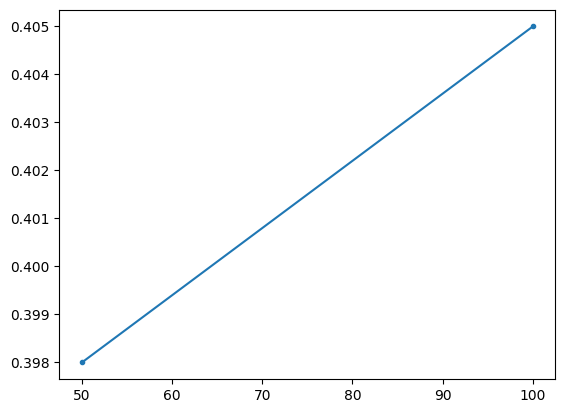

In [ ]:
plt.plot([50, 100], [i[0] for i in silver_simpda], marker='.')

In [ ]:
#Spearman
silver_simpda = [(0.388, 0.023), (0.394, 0.026)]
silver_humli = [(0.660, 0.039), (0.675, 0.055)]
silver_simpda2022 = [(0.400, 0.026), (0.401, 0.028)]
gold_simpda = [(0.411, 0.033), (0.410, 0.024)]
gold_humli = [(0.697, 0.030), (0.704, 0.032)]
gold_simpda2022 = [(0.459, 0.019), (0.465, 0.025)]